# Model Evaluation and Loose Ends
## Foundations of Machine Learning
## ! git clone https://github.com/DS3001/model_evaluation

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Evaluating and Comparing Models
- We've covered four models: $k$ nearest neighbor, $k$ means clustering, linear models, and decision trees
- These models each introduced key ideas and skills for machine learning, and drew conceptual boundaries like supervised v. unsupervised or regression v. classification
- The risk of learning a big dictionary of models is that their common elements are obscured by an over-emphasis on their individual mechanics: These tools appear different, but we don't want to lose sight of their common features
- This lecture focuses on some general ways of evaluating whether the model is doing a "good job" or not and comparing results from models to one another
- We're building towards ideas about whether your model will actually work for "out of sample" or test predictions, rather than just perform well on the data on which it was trained: This theme will get clearer and more important as we go forward

## Caution When Splitting for Training/Testing
- When preprocessing/feature engineering, some tasks depend on the entire vector of data (e.g. maxmin normalization) and some tasks do not (e.g. polynomial expansion)
- If you are going to do a training/test split, you should
    1. Do the tasks that do not depend on all of the data
    2. Split the data
    3. Do the tasks that require all of the data only on the training data, and save the details of the transformations to apply them to the test data
- For example, if you want to $z$-score normalize the data, save the mean and standard deviation from the training data. When you process the testing data, apply the same transformation, don't create a new one
- In practice, if you only get a single data point to make a prediction for, how would you compute its standard deviation?

## Pipelining
- At some point, it must have occurred to you, "This cleaning and model building seems very tedious"
- Pipelining involves building a chunk of code that abstracts the preprocessing steps
- Basically, the data get split into numeric/categorical/etc. and cleaned separately, then models are applied
- This can feel like a lot of steps:
    1. Finalize data from Pandas, specifically dropping any `.nan`'s you don't want to impute
    2. Create separate, variable pipelines to preprocess different kinds of data
    3. Build a `ColumnTransformer` that applies your variable preprocessing pipelines
    4. Build model-specific pipelines (for a linear model, a tree, kNN, etc.) 
    5. Make your train-test split
    6. Fit your models 
    7. Extract results
- These steps aren't sacred, I just made them up to organize the thinking: You could consolidate them or switch their order, to some extent
- We'll do an example with an extract of the AirBnB data just to look at how this works in general

![Pipelining Process](./data/pipelining.png)

## Pipelining
- There are two key pieces to the code:
    - A pipeline is a list of steps: `pipe = Pipeline(steps = [('stepName1', Fcn1() ),('stepName2', Fcn2() ),...] )`
    - A column transformer is a list of transformers by variable type: With `cat_vars` a list of categorical variables and `num_vars` a list of numeric variables, `preprocessor = ColumnTransformer(transformers = [('cat', cat_pipeline, cat_vars),('num', num_pipelin, num_vars)])`

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = pd.read_csv('./data/Q1_clean.csv')
df.head()

,Price,Review Scores Rating,Neighbourhood,Property Type,Room Type
0,549,96.0,Manhattan,Apartment,Private room
1,149,100.0,Brooklyn,Apartment,Entire home/apt
2,250,100.0,Manhattan,Apartment,Entire home/apt
3,90,94.0,Brooklyn,Apartment,Private room
4,270,90.0,Manhattan,Apartment,Entire home/apt


Linear Model rsq:  0.08275147165203889
[ 75.64199598 127.78186238 183.83654033  96.66854284 156.27068208
   9.23656158]
Tree rsq:  0.08079372541798002


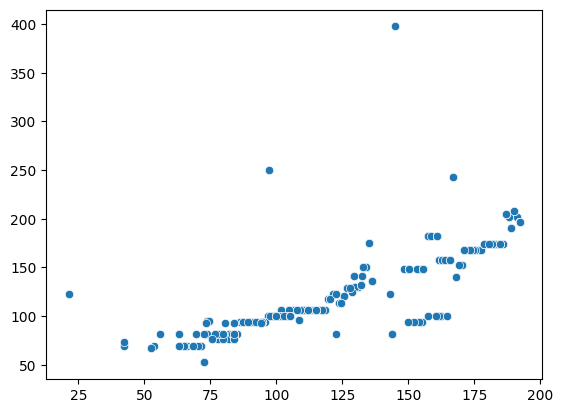

In [85]:
# Pipeline tools:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
# Variable transformers for cleaning:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
# Analytics:
from sklearn.tree import DecisionTreeRegressor, plot_tree 
from sklearn.linear_model import LinearRegression

# 1. Finalize data from Pandas:
y = df['Price']
Z = df.loc[:,['Review Scores Rating', 'Neighbourhood '] ]

# 2. Set up variable preprocessing:
cat_vars = ['Neighbourhood '] # List of categorical variables
num_vars = ['Review Scores Rating'] # List of numeric variables
cat_pipeline = Pipeline(steps = [('ohc', OneHotEncoder(sparse_output=False))]) # One hot encoding
num_pipeline = Pipeline(steps = [('maxmin', StandardScaler()), # Maxmin scaling
                              ('imputer', SimpleImputer(strategy='median'))]) # Imputation for missing values

# 3. Column transformer:
preprocessor = ColumnTransformer(
    transformers = [('cat', cat_pipeline, cat_vars), # Transform cat_vars by cat_pipeline
                    ('num', num_pipeline, num_vars)]) # Transform num_vars by num_pipeline

# 4. Create model-specific pipelines:
lm_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                ('linreg', LinearRegression(fit_intercept=False))]) # Link preprocessor to model
tree_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                ('tree', DecisionTreeRegressor(max_depth = 6))]) # Link preprocessor to model

# 5. Train-test split:
X_train, X_test, y_train, y_test = train_test_split(Z, y, # Feature and target variables
                                                    test_size=.2) # For replication purposes

# 6. Fit the models:
lm = lm_pipe.fit(X_train, y_train)
tree = tree_pipe.fit(X_train, y_train)

# 7. Extract results:
print('Linear Model rsq: ', lm.score(X_test, y_test) ) # R-squared
print(lm.named_steps['linreg'].coef_) # Regression coefficients
y_hat_lm = lm.predict(X_test) # Predicted values

print('Tree rsq: ', tree.score(X_test, y_test) ) # R-squared
y_hat_tree = tree.predict(X_test) 

sns.scatterplot(x=y_hat_lm, y=y_hat_tree)
plt.show()


## Model Evaluation: What is a Model?
- A **model** is a function that maps cases $\hat{x}$ into predictions $\hat{y}$ using a rule $m(\hat{x},b,k) = \hat{y}$ where $b$ are **parameters** (e.g. weights in linear regression, splits in a decision tree) and $k$ are **hyperparameters** (number of neighbors in $k$-NN, which variables to include in linear regression, how complex the tree is allowed to be)
- What is a hyperparameter? A hyperparameter is any feature of a model that can trivially improve fit on training data, independently of the data (e.g. $k=1$ in $k$-NN, $k=N$ in $k$-MC, adding more regressors in linear models, adding more splits and variables to decision trees)
- The parameters $b$ are selected using a training set, and hyperparameters $k$ are selected by comparisons of the fitted models on a testing set (e.g. the scree plot, the CART confusion matrix)
- How do we fit and compare models?

## Revisiting Regression
- What is a regression?
- The **predicted value** for values $\hat{x}_i$ is the output of the model, using its parameters $b$ like regression weights and hyperparameters $k$ (e.g. the variables selected or the number of neighbors or the size of the tree):
$$ \hat{y}_i = m(\hat{x}_i, b, k) $$
We often make scatterplots of the predicted and actual values to evaluate whether the predictions and true values exhibit a strong association or not: A big cloud of points with no trend at all suggests we aren't doing a great job.
- The **residual** or **error** for observation $i$ is the difference between the true outcome and the predicted value,
$$
e_i = y_i - \hat{y}_i
$$
- This is the simplest way to evaluate how far off the model is from the truth, and we often make kernel density plots of the residuals to visualize the extent to which there are still clues left in the errors about whether we're epxloiting all the data as effectively as we can

## Measures of Fit for Regression: SSE, MSE, and RMSE
- In regression settings, we typically pick our model parameters to minimize the **Sum of Squared Error**:
$$ \text{SSE}(b,k) = \sum_{i=1}^N (y_i - m(x_i,b,k))^2, $$
or **Mean Squared Error**,
$$ \text{MSE}(b,k) = \dfrac{1}{N}\sum_{i=1}^N (y_i - m(x_i,b,k))^2, $$
or **Root Mean Squared Error**,
$$ \text{RMSE}(b,k) = \sqrt{\dfrac{1}{N}\sum_{i=1}^N (y_i - m(x_i,b,k))^2}. $$
- These are all roughly the same thing, since if $(b_1,k_1)$ does better in terms of any of these metrics than $(b_2,k_2)$, then it does better for all of them
- In practice, RMSE is a bit more interpretable, and SSE is a bit more computationally easy to work with
- There are dozens of these

## Measures of Fit: $R^2$
- The *Sum of Squared Error* (SSE) is
$$
\text{SSE} = \sum_{i=1}^N (y_i - \hat{y}_i)^2
$$
and the *Total Sum of Squares* (TSS) is
$$
\text{TSS} = \sum_{i=1}^N (y_i - \bar{y})^2, \quad \text{ where }\bar{y} = \dfrac{1}{N}\sum_{i=1}^N y_i
$$
- The $R^2$ measure or *coefficient of determination* is
$$
R^2 = 1 - \dfrac{SSE}{TSS}
$$
- This is the proportion of the variation in the data explained by the model that isn't captured by just predicting the sample average (the simplest predictor of all)

## Measures of Fit
- The mean is our simplest predictor of a numeric outcome: It doesn't use any features/covariates/controls, and just predicts the average outcome regardless of circumstance
- If you prefer to think probabilistically, let *Mean Squared Error* (MSE) be
$$
\text{MSE} = \dfrac{1}{N} \sum_{i=1}^N (y_i - \hat{y}_i)^2
$$
and the *variance of $Y$* be
$$
\sigma_Y^2 = \dfrac{1}{N} \sum_{i=1}^N (y_i - \bar{y})^2,
$$
and then the $R^2$ measure can be written
$$
R^2 = \dfrac{\sigma_Y^2-\text{MSE}}{\sigma_Y^2},
$$
the proportion of the variance in $Y$ that can be explained by the model.
- On the training set, this is between 0 and 1. On a testing set, it can be negative.

## Splitting the Sample: Training and Validation
- If you fit a model and then evaluate its performance on the data you used, you are certain to overestimate the performance of the model
- Models with hyper-parameters (e.g. $k$ in $k$NN) are typically *greedy* or *trivial*: They will do better with in-sample fit as the complexity of the hyper-parameters goes to extremes, but will do poorly predicting outcomes for new data (under-fitting, over-fitting)
- This is a form of *confirmation bias*: Our models are formalizations of past outcomes, and we don't want them to be overly sensitive to the quirks of past data but instead be robust to those quirks and useful for estimating future outcomes

## Case Study: Diabetes Data
- `'./data/diabetes-dataset.csv'`
- 1000 patients with characteristics like Age, BloodPressure, BMI, Insulin levels, and past Pregnancies
- Outcome is whether the patient has diabetes or not
- The goal is to predict the likelihood someone has diabetes from other health characteristics

In [86]:
df = pd.read_csv('./data/diabetes-dataset.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


In [87]:
y = df['Outcome'] # Response/target/outcome variable
print(y.describe())
X = df.drop('Outcome',axis=1) # Feature/predictor/control variables
X.head()

count    2000.000000
mean        0.342000
std         0.474498
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Outcome, dtype: float64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,2,138,62,35,0,33.6,0.127,47
1,0,84,82,31,125,38.2,0.233,23
2,0,145,0,0,0,44.2,0.630,31
3,0,135,68,42,250,42.3,0.365,24
4,1,139,62,41,480,40.7,0.536,21


In [88]:
X.describe() # Data look very clean in terms of nan's

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,3.703500,121.182500,69.145500,20.935000,80.254000,32.193000,0.470930,33.090500
std,3.306063,32.068636,19.188315,16.103243,111.180534,8.149901,0.323553,11.786423
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,63.500000,0.000000,0.000000,27.375000,0.244000,24.000000
50%,3.000000,117.000000,72.000000,23.000000,40.000000,32.300000,0.376000,29.000000
75%,6.000000,141.000000,80.000000,32.000000,130.000000,36.800000,0.624000,40.000000
max,17.000000,199.000000,122.000000,110.000000,744.000000,80.600000,2.420000,81.000000


<Axes: >

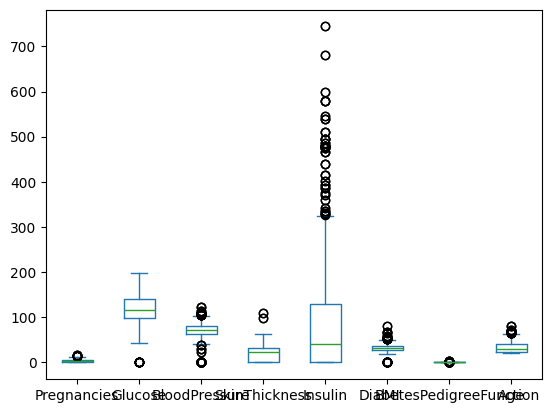

In [89]:
X.plot.box() # Hmm, outliers

## Method-by-Method:

In [90]:
## Test-train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
TSS = np.sum( (y_test - y_train.mean())**2 )
N_test = len(y_test)

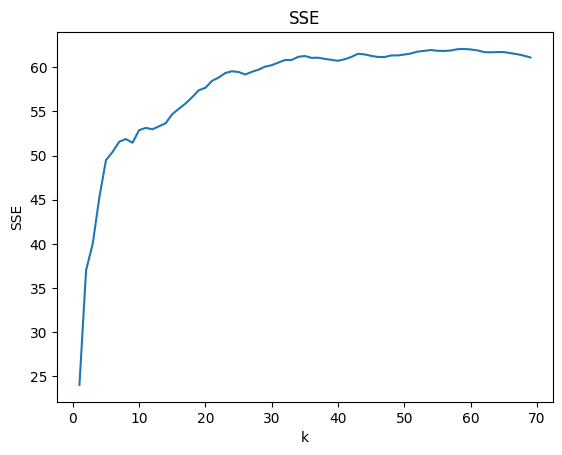

KNeighborsRegressor(n_neighbors=3)


In [91]:
## kNN sample code:
from sklearn.neighbors import KNeighborsRegressor

# Maxmin normalization function:
def maxmin(z):
    z = (z-min(z))/(max(z)-min(z))
    return(z)

# Apply maxmin to each column of X:
X_train_knn = X_train.apply(maxmin)
X_test_knn = X_test.apply(maxmin)

# Determine optimal k:
k_bar = 70
k_grid = np.arange(1,k_bar) # The range of k's to consider
SSE = np.zeros(k_bar-1) # For comparison purposes, store the training error
for k in range(k_bar-1):
    model = KNeighborsRegressor(n_neighbors=k+1) # Create a sk model for k
    fitted_model = model.fit(X_train_knn,y_train) # Train the model on our data
    y_hat = fitted_model.predict(X_test_knn) # Predict values for test set
    SSE[k] = np.sum( (y_test-y_hat)**2 ) # Save the computed SSE
SSE_min = np.min(SSE) # Lowest recorded SSE
min_index = np.where(SSE==SSE_min) # Find the indices of y that equal the minimum
k_star = k_grid[min_index][0] # Find the optimal value of k

## SSE plot:
plt.plot(k_grid,SSE)
plt.xlabel("k")
plt.ylabel("SSE")
plt.title('SSE')
plt.show()

## Fit optimal model:
model = KNeighborsRegressor(n_neighbors=max(3,k_star))
knn_star = model.fit(X_train_knn,y_train)
print(knn_star)
y_hat_knn = knn_star.predict(X_test_knn)
residuals_knn = y_test - y_hat_knn

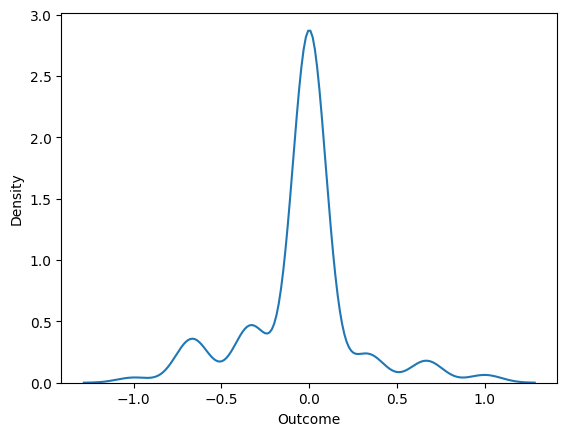

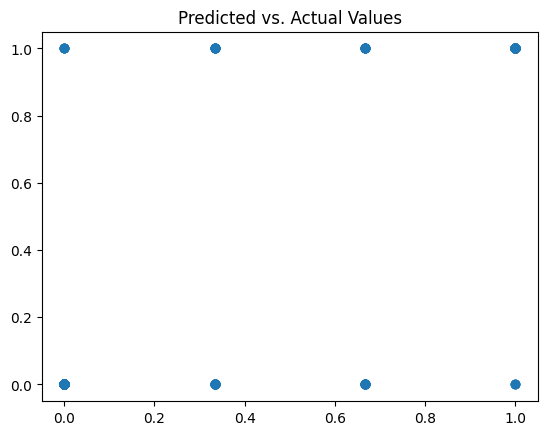

In [92]:
## Residual plot:
sns.kdeplot(residuals_knn)
plt.show()

## True versus predicted plot:
plt.scatter(x=y_hat_knn,y=y_test)
plt.title('Predicted vs. Actual Values')
plt.show()

## Metrics:
SSE_knn = np.sum( (y_test-y_hat_knn)**2 )
MSE_knn = SSE_knn/N_test
RMSE_knn = (SSE_knn/N_test)**(1/2)
R2_knn = 1 - SSE_knn/TSS

0.4109220945138685


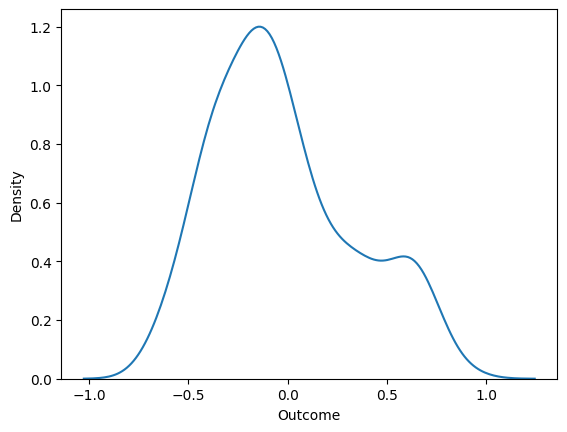

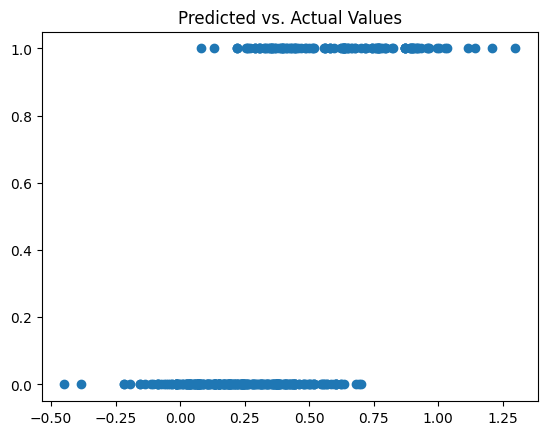

In [93]:
## Linear Model sample code:
from sklearn.linear_model import LinearRegression # Import linear regression model
from sklearn.preprocessing import PolynomialFeatures

# Expand features
expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
#
Z_train = expander.fit_transform(X_train) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
X_train_lm = pd.DataFrame(data=Z_train, columns = names) # Create a new, expanded dataframe
#
Z_test = expander.fit_transform(X_test) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
X_test_lm = pd.DataFrame(data=Z_test, columns = names) # Create a new, expanded dataframe

# Fit the model and get the R2 measure:
reg = LinearRegression().fit(X_train_lm, y_train) # Fit the linear model
print(reg.score(X_test_lm, y_test)) # R squared measure

# Predicted values:
y_hat_lm = reg.predict(X_test_lm)
residuals_lm = y_test - y_hat_lm

## Residual plot:
sns.kdeplot(residuals_lm)
plt.show()

## True versus predicted plot:
plt.scatter(x=y_hat_lm,y=y_test)
plt.title('Predicted vs. Actual Values')
plt.show()

## Metrics:
SSE_lm = np.sum( (y_test-y_hat_lm)**2 )
MSE_lm = SSE_lm/N_test
RMSE_lm = (SSE_lm/N_test)**(1/2)
R2_lm = 1 - SSE_lm/TSS

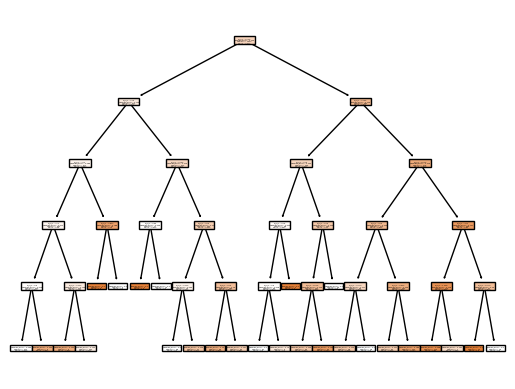

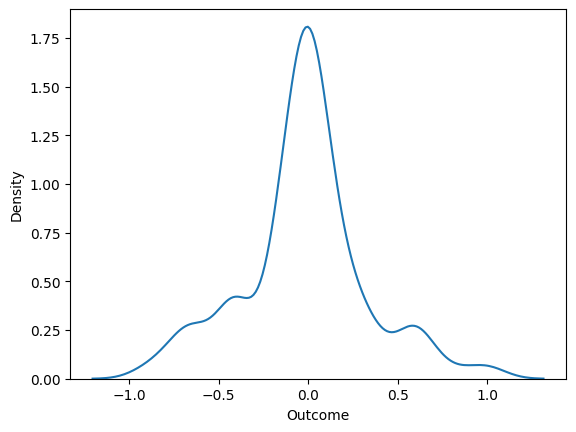

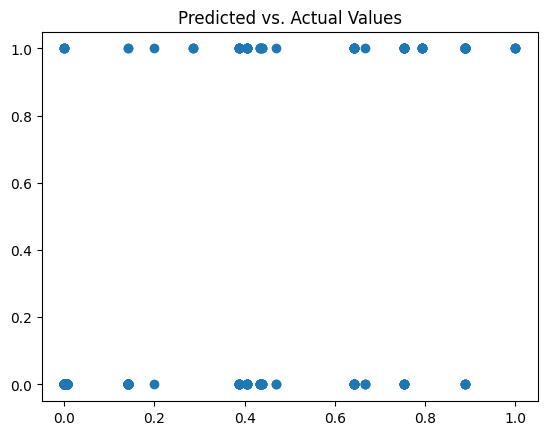

In [94]:
## Decision Trees sample code:
from sklearn import tree

model = tree.DecisionTreeRegressor(max_depth=5) # Fit the classifier
cart = model.fit(X_train, y_train)
tree.plot_tree(cart,filled=True)
plt.show()

## Make Predictions on the Test Set
y_hat_cart = cart.predict(X_test)
residuals_cart = y_test - y_hat_cart

## Residual plot:
sns.kdeplot(residuals_cart)
plt.show()

## True versus predicted plot:
plt.scatter(x=y_hat_cart,y=y_test)
plt.title('Predicted vs. Actual Values')
plt.show()

## Metrics:
SSE_cart = np.sum( (y_test-y_hat_cart)**2 )
MSE_cart = (1/N_test)*np.sum( (y_test-y_hat_cart)**2 )
RMSE_cart = (SSE_cart/N_test)**(1/2)
R2_cart = 1 - SSE_cart/TSS


## Pipeline Approach
- Instead of writing three separate but very similar chunks of code, let's write one using the Pipeline/ColumnTransformer approach

In [95]:
# Pipeline tools:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
# Variable transformers for cleaning:
from sklearn.preprocessing import RobustScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
# Analytics:
from sklearn.tree import DecisionTreeRegressor, plot_tree 
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# 1. Finalize data from Pandas:
y = df['Outcome'] # Response/target/outcome variable
X = df.drop('Outcome',axis=1) # Feature/predictor/control variables

# 2. Set up variable preprocessing:
cat_vars = [] # List of categorical variables
num_vars = ['Pregnancies',
            'Glucose',
            'BloodPressure',
            'SkinThickness',
            'Insulin',
            'BMI',
            'DiabetesPedigreeFunction',
            'Age'] # List of numeric variables
cat_pipeline = Pipeline(steps = [('ohc', OneHotEncoder(sparse_output=False))]) # One hot encoding
num_pipeline = Pipeline(steps = [('winsorize', RobustScaler()), # Winsorize
                              ('imputer', SimpleImputer(strategy='median'))]) # Imputation for missing values
poly_pipeline = Pipeline(steps = [('winsorize', RobustScaler()),
                                  ('expander',PolynomialFeatures(degree=2,include_bias=False)) ] ) # Polynomial Expander
unif_pipeline = Pipeline(steps = [('winsorize', RobustScaler()),
                                  ('maxmin',StandardScaler()) ] ) # Maxmin normalize

# 3. Column transformer:
preprocessor = ColumnTransformer(
    transformers = [('cat', cat_pipeline, cat_vars), # Transform cat_vars by cat_pipeline                  
                    ('poly', poly_pipeline, num_vars)]) # Transform num_vars by num_pipeline
preprocessor_knn = ColumnTransformer(
    transformers = [('cat', cat_pipeline, cat_vars), # Transform cat_vars by cat_pipeline
                    ('unif', unif_pipeline, num_vars)]) # Transform num_vars by num_pipeline

# 4. Create model-specific pipelines:
lm_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                ('linreg', LinearRegression(fit_intercept=True))]) # Link preprocessor to model
tree_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                ('tree', DecisionTreeRegressor(max_depth = 10))]) # Link preprocessor to model
knn_pipe = Pipeline(steps=[('preprocessor', preprocessor_knn),
                ('knn', KNeighborsRegressor(n_neighbors = 35))]) # Link preprocessor to model

# 5. Train-test split:
X_train, X_test, y_train, y_test = train_test_split(X, y, # Feature and target variables
                                                    test_size=.2,
                                                    random_state=10) # For replication purposes

# 6. Fit the models:
lm = lm_pipe.fit(X_train, y_train)
tree = tree_pipe.fit(X_train, y_train)
knn = knn_pipe.fit(X_train,y_train)

Linear Model rsq:  0.41092209451393924
Slope Coefficients:  [-2.17937811e-02  2.46952338e-01 -2.79407633e-02 -4.96701166e-02
 -5.13971679e-02  1.29794090e-01  1.04985142e-01  2.11224099e-01
  7.82583114e-02 -3.18127947e-02 -3.47629466e-02 -2.78984098e-02
  4.71025562e-02  2.55020853e-02  6.45721402e-02 -7.80345874e-02
  5.67187159e-02 -3.22781135e-02 -1.32573220e-02  6.00237568e-03
  1.82838133e-02 -3.84868442e-02 -3.20252750e-02 -6.16973217e-05
  8.08577572e-03  3.68702719e-02  2.20548424e-02 -2.14991714e-03
  5.76573147e-02 -8.38626068e-02  1.59834367e-01  3.66692245e-02
  1.09642313e-01  3.98867804e-02  1.06967864e-02 -9.06739900e-02
 -4.54854969e-02  3.76710871e-02 -6.92746957e-03 -3.46507448e-02
 -4.35702107e-02 -1.59384010e-02 -2.53857687e-02 -9.48053796e-02]
Intercept:  0.27902405645892603


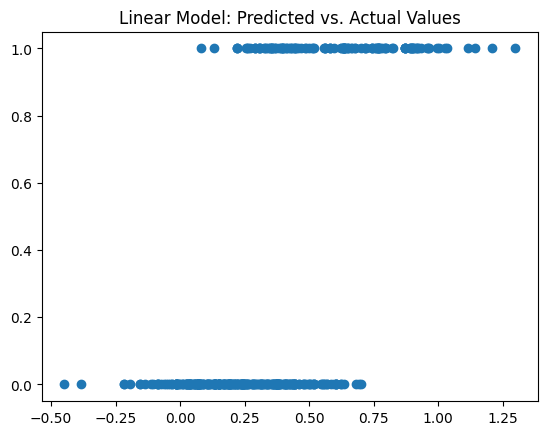

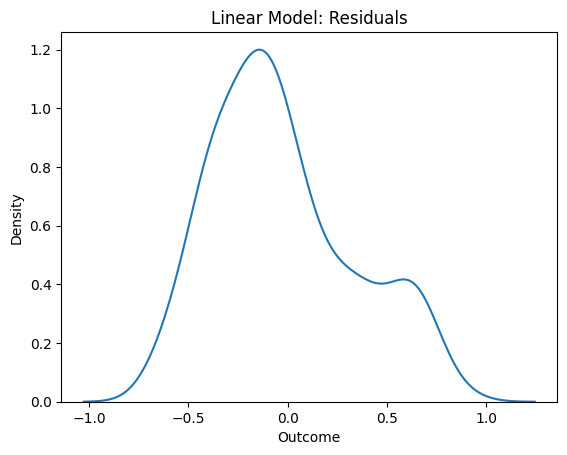

Tree rsq:  0.7697518637766605


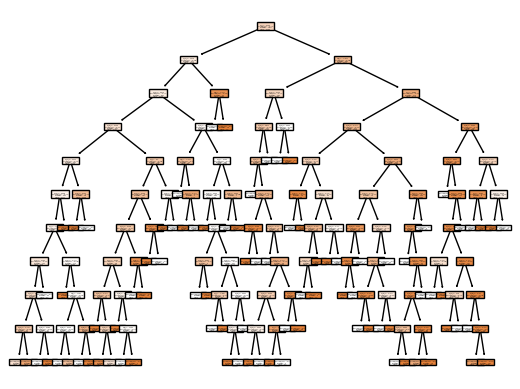

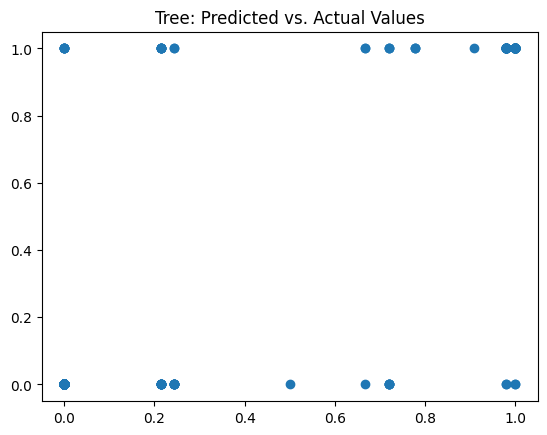

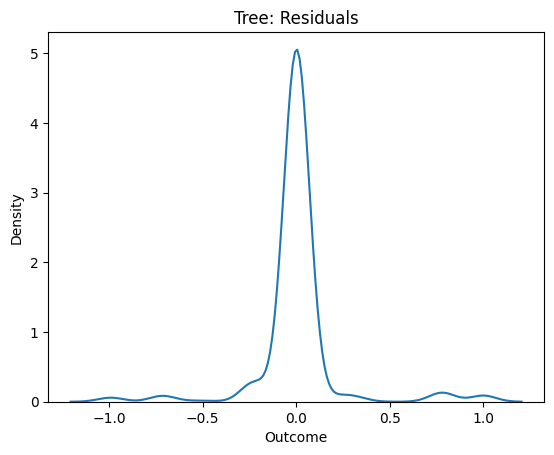

kNN rsq:  0.31300605602211373


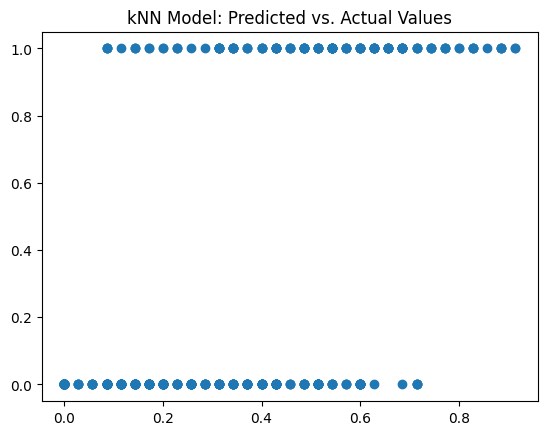

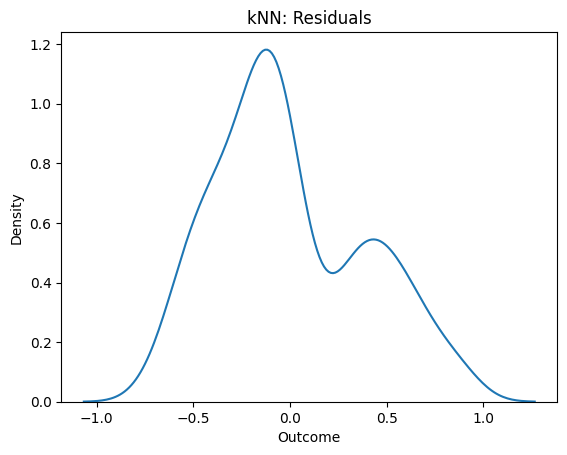

In [96]:
# 7. Extract Results:

# Linear model:

N_test = len(y_test)
TSS = np.sum( (y_test - y_train.mean())**2 )

print('Linear Model rsq: ', lm.score(X_test, y_test) ) # R-squared
y_hat_lm = lm.predict(X_test) # Predicted values
SSE_lm = np.sum( (y_test-y_hat_lm)**2 )
MSE_lm = (1/N_test)*np.sum( (y_test-y_hat_lm)**2 )
RMSE_lm = (SSE_lm/N_test)**(1/2)
R2_lm = 1 - SSE_lm/TSS

print('Slope Coefficients: ', lm_pipe.named_steps['linreg'].coef_) # Regression coefficients
print('Intercept: ', lm_pipe.named_steps['linreg'].intercept_) # Regression coefficients

plt.scatter(x=y_hat_lm,y=y_test)
plt.title('Linear Model: Predicted vs. Actual Values')
plt.show()

sns.kdeplot(x=y_test - y_hat_lm).set_title('Linear Model: Residuals')
plt.show()

##########################################################

# Tree:

print('Tree rsq: ', tree.score(X_test, y_test) ) # R-squared
y_hat_tree = tree.predict(X_test) 
SSE_tree = np.sum( (y_test-y_hat_tree)**2 )
MSE_tree = (1/N_test)*np.sum( (y_test-y_hat_tree)**2 )
RMSE_tree = (SSE_tree/N_test)**(1/2)
R2_tree = 1 - SSE_tree/TSS

plot_tree(tree_pipe.named_steps['tree'],filled=True)
plt.show()

plt.scatter(x=y_hat_tree,y=y_test)
plt.title('Tree: Predicted vs. Actual Values')
plt.show()

sns.kdeplot(x=y_test - y_hat_tree).set_title('Tree: Residuals')
plt.show()

##########################################################

# k Nearest Neighbor:

print('kNN rsq: ', knn.score(X_test, y_test) ) # R-squared
y_hat_knn = knn.predict(X_test)
SSE_knn = np.sum( (y_test-y_hat_knn)**2 )
MSE_knn = (1/N_test)*np.sum( (y_test-y_hat_knn)**2 )
RMSE_knn = (SSE_knn/N_test)**(1/2)
R2_knn = 1 - SSE_knn/TSS

plt.scatter(x=y_hat_knn,y=y_test)
plt.title('kNN Model: Predicted vs. Actual Values')
plt.show()

sns.kdeplot(x=y_test - y_hat_knn).set_title('kNN: Residuals')
plt.show()

In [97]:
## Comparison Table:
gdf = pd.DataFrame({'SSE':[SSE_knn,SSE_lm,SSE_cart],
                    'MSE':[MSE_knn,MSE_lm,MSE_cart],
                    'RMSE':[RMSE_knn,RMSE_lm,RMSE_cart],
                    'R2':[R2_knn,R2_lm,R2_cart]})
gdf.index = ['kNN','LM','Tree']
gdf.head()

,SSE,MSE,RMSE,R2
kNN,60.522449,0.151306,0.388981,0.314029
LM,51.896291,0.129741,0.360195,0.411799
Tree,48.268268,0.120671,0.347377,0.452920


## General Classification
- Suppose we want to put aside the continuous nature of the predictors, and predict categories rather than numeric values
- Instead of thinking of the categories 0 and 1 as numbers and a prediction as a probability, think of the categories 0 and 1 as just categories with, perhaps, no intrinsic numeric meaning

## Classification
- The main distinction with binary classification versus regression on a binary outcome is that we predict a hard 0 or hard 1 for every case, rather than a probability between 0 and 1
    - For $k$-NN, we typically implement majority vote for the neighbors
    - For CART, we take the majority class in the terminal node
    - For linear models, we set a threshold $t$ and if $b \cdot x \ge t$, we predict 1 and otherwise predict 0; the threshold $t$ is usually $1/2$
- If we were doing classification with more categories, linear models would not be feasible (support vector machines/linear discrimination analysis/multinomial logit are all models that use linear models as a workhorse or puzzle piece to do multiclass discrimination)

## Confusion Matrices
- We typically represent a binary classifier's performance on the testing/validation set in a cross tabulation:

|  | Predicted Negative | Predicted Positive|
| :---: | :---:| :---: |
| Actual Negative | True Negative (TN) | False Positive (FP) |
| Actual Positive | False Negative (FN) | True Positive (TP) |

- We are obviously most concerned about False Positive and False Negatives --- These are the cases in which the model can produce significant harm by failing to correctly predict the outome
- In the real world, the consequences of a FP or FN are probably not the same, and you should keep this in mind (failing to detect a disease [FN] has more severe consequences for a patient than mistakenly detecting a disase that isn't there [FP])
- Confusion Matrices are cross-tabulations of actual versus predicted values, and all of the Fit Measures we'll see are calculations on those cross-tabs intended to mimic a probability or conditional probability ("Given that I've predicted a positive..." or "Given that my prediction is correct..." or "Given that the truth is a positive...", etc.)

## Fit Measures
- Let $\text{Tot} = TN + FP + FN + TP$, the total number of cases
- **Accuracy**: (Propotion correctly predicted)
$$Acc = \dfrac{TP+TN}{\text{Tot}} $$
- **Error rate**: (Proportion incorrectly predicted)
$$ER = \dfrac{FP+FN}{\text{Tot}}= 1-Acc$$
- **True Positive Rate** or **Sensitivity**: (Given a positive prediction, proportion correct)
$$TPR = \dfrac{TP}{TP+FN}$$  
- **True Negative Rate** or **Specificity**: (Given a negative prediction, proportion correct)
$$
TNR = \dfrac{TN}{TN+FP}
$$

## Fit Measures
- **Prevalence**: (Proportion of positive predictions)
$$Prev = \dfrac{TP+FN}{\text{Tot}}$$  
- **Precision**: (Given a positive prediction, proportion correct)
$$Prec = \dfrac{TP}{TP+FP}$$
- **False Positive Rate**, False Alarm Rate, Miss Rate: (Given a positive prediction, proportion incorrect)
$$FPR = \dfrac{FP}{TN+FP}$$

## Fit Measures
- We could spend all day on this...
    - The **F1** score (harmonic mean of precision and sensitivity): $$ F_1 = \dfrac{2 \times TP}{2 \times TP + FP + FN} $$
    - The **Fowlkes-Mallows Index** (geometric mean of preceision and false positive rate):
$$ FM = \sqrt{ \dfrac{TP}{TP+FP} \times \dfrac{FP}{TP+FN}}$$
- There are a lot of these...

## An $R^2$ For Classification
- If Accuracy is somewhat like SSE, in the sense that it is a raw measure of performance but a challenge to compare across models and data, what is the $R^2$ of classification?
- The **Matthews Correlation Coefficient** (MCC):
$$ MCC = \dfrac{TP \times TN - FP \times FN}{\sqrt{ (TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$
- This ranges between -1 and 1, with 1 being a perfect predictor, 0 being no better than random guessing, and -1 being very bad. It is increasing in $TP$ and $TN$, and decreasing in $FP$ and $FN$.
- You can see where the bounds come from by setting, for example, $TP=0$ and $TN=0$, which means all the results are false:
$$ \dfrac{ - FP \times FN}{\sqrt{ (FP)(FN)(FP)(FN)}} = -1 $$
or $FP = 0$ and $FN = 0$,
$$ \dfrac{TP \times TN }{\sqrt{ (TP)(TP)(TN)(TN)}} = 1$$
- Some people argue (reasonably convincingly) this is the best single measure of classifier performance; in general, you should think about all the possible consequences of the tools you create
- If you really want to get into a classification problem, you should also read up on **Receiver Operating Characteristics (ROC) curves** and the **Area Under the Curve** measure; this takes a little too much time to do in this class, but practictioners really favor this framework for evaluating the performance of classifiers

In [98]:
## Reload the data and reclean it:
df = pd.read_csv('./data/diabetes-dataset.csv')
df.head()

y = df['Outcome']
X = df.drop('Outcome',axis=1)

## Test-train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

def performance(y_test,y_hat): # Sample code to compute classifier performance
    tab = pd.crosstab(np.array(y_hat),np.array(y_test)) # Compute confusion matrix
    #
    # Get entries from the confusion matrix:
    tp = tab.iloc[0,0]
    tn = tab.iloc[1,1]
    fp = tab.iloc[0,1]
    fn = tab.iloc[1,0]
    tot = tp+tn+fp+fn
    #
    # Compute performance statistics:
    acc = (tp+tn)/tot
    spec = tn/(tp+fn)
    sens = tp/(tp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    #
    # Return a dictionary including the confusion matrix and metrics:
    return({'confusion_matrix':tab,
            'accuracy':acc,
            'specificity':spec,
            'sensitivity':sens,
            'mcc':mcc})


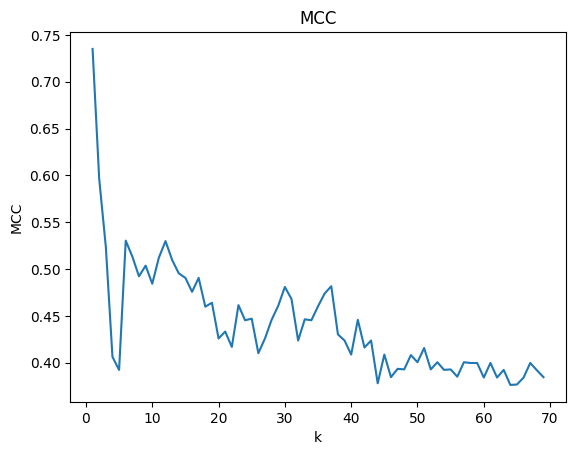

{'confusion_matrix': col_0    0   1
row_0         
0      237  42
1       39  82, 'accuracy': 0.7975, 'specificity': 0.2971014492753623, 'sensitivity': 0.8586956521739131, 'mcc': 0.5235548977307792}


In [99]:
## kNN Classifier sample code:
from sklearn.neighbors import KNeighborsClassifier

# Maxmin normalization function:
def maxmin(z):
    z = (z-min(z))/(max(z)-min(z))
    return(z)

# Apply maxmin to each column of X:
X_train_knn = X_train.apply(maxmin)
X_test_knn = X_test.apply(maxmin)

# Determine optimal k:
k_bar = 70
k_grid = np.arange(1,k_bar) # The range of k's to consider
MCC = np.zeros(k_bar-1)
for k in range(k_bar-1):
    model = KNeighborsClassifier(n_neighbors=k+1) # Create a sk model for k
    fitted_model = model.fit(X_train_knn,y_train) # Train the model on our data
    y_hat = fitted_model.predict(X_test_knn) # Predict values for test set
    perf = performance(y_test,y_hat)
    MCC[k] = perf['mcc']

MCC_max = np.max(MCC) # Lowest recorded SSE
max_index = np.where(MCC==MCC_max) # Find the indices of y that equal the minimum
k_star = k_grid[max_index][0] # Find the optimal value of k

## SSE plot:
plt.plot(k_grid,MCC)
plt.xlabel("k")
plt.ylabel("MCC")
plt.title('MCC')
plt.show()

## Fit optimal model:
model = KNeighborsClassifier(n_neighbors=np.max([3,k_star]))
knn_star = model.fit(X_train_knn,y_train)
y_hat_knn = knn_star.predict(X_test_knn)

## Compute performance:
perf_knn = performance(y_test,y_hat_knn)
print(perf_knn)

In [100]:
## Linear Model sample code:
from sklearn.linear_model import LinearRegression # Import linear regression model
from sklearn.preprocessing import PolynomialFeatures

# Expand features
expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
#
Z_train = expander.fit_transform(X_train) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
X_train_lm = pd.DataFrame(data=Z_train, columns = names) # Create a new, expanded dataframe
#
Z_test = expander.fit_transform(X_test) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
X_test_lm = pd.DataFrame(data=Z_test, columns = names) # Create a new, expanded dataframe

# Fit the model and get the R2 measure:
reg = LinearRegression().fit(X_train_lm, y_train) # Fit the linear model

# Predicted values:
y_hat_lm = reg.predict(X_test_lm) # Compute predicted values from the model
y_hat_lm = np.round(y_hat_lm) # Round values to 0 or 1

# Compute performance:
perf_lm = performance(y_test,y_hat_lm)
print(perf_lm)

{'confusion_matrix': col_0    0   1
row_0         
-1.0     2   0
 0.0   246  58
 1.0    28  66, 'accuracy': 0.19607843137254902, 'specificity': 0.23387096774193547, 'sensitivity': 0.008064516129032258, 'mcc': 0.03922530800103284}


{'confusion_matrix': col_0    0   1
row_0         
0      245  48
1       31  76, 'accuracy': 0.8025, 'specificity': 0.2753623188405797, 'sensitivity': 0.8876811594202898, 'mcc': 0.5230184184240534}


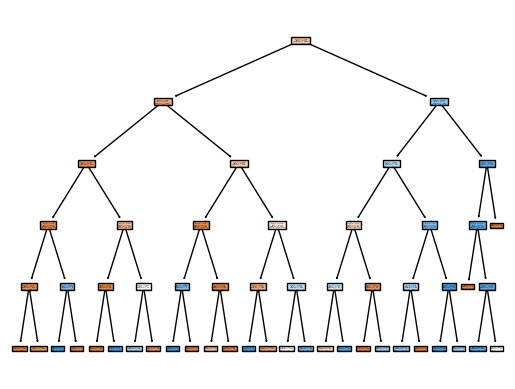

In [101]:
## Decision Trees sample code:
from sklearn import tree

model = tree.DecisionTreeClassifier(max_depth=5) # Fit the classifier
cart = model.fit(X_train, y_train)
tree.plot_tree(cart,filled=True)

## Make Predictions on the Test Set
y_hat_cart = cart.predict(X_test)

# Compute performance:
perf_cart = performance(y_test,y_hat_cart)
print(perf_cart)


In [102]:
## Comparison table:

gdf = pd.DataFrame({'Accuracy':[perf_knn['accuracy'],perf_lm['accuracy'],perf_cart['accuracy']],
                    'Sensitivity':[perf_knn['sensitivity'],perf_lm['sensitivity'],perf_cart['sensitivity']],
                    'Specificity':[perf_knn['specificity'],perf_lm['specificity'],perf_cart['specificity']],
                    'MCC':[perf_knn['mcc'],perf_lm['mcc'],perf_cart['mcc']]})
gdf.index = ['kNN','LM','CART']
gdf.head()


,Accuracy,Sensitivity,Specificity,MCC
kNN,0.797500,0.858696,0.297101,0.523555
LM,0.196078,0.008065,0.233871,0.039225
CART,0.802500,0.887681,0.275362,0.523018


In [103]:
# Pipeline tools:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
# Variable transformers for cleaning:
from sklearn.preprocessing import RobustScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
# Analytics:
from sklearn.tree import DecisionTreeClassifier, plot_tree 
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef, accuracy_score

# 1. Finalize data from Pandas:
y = df['Outcome'] # Response/target/outcome variable
X = df.drop('Outcome',axis=1) # Feature/predictor/control variables

# 2. Set up variable preprocessing:
cat_vars = [] # List of categorical variables
num_vars = ['Pregnancies',
            'Glucose',
            'BloodPressure',
            'SkinThickness',
            'Insulin',
            'BMI',
            'DiabetesPedigreeFunction',
            'Age'] # List of numeric variables
cat_pipeline = Pipeline(steps = [('ohc', OneHotEncoder(sparse_output=False))]) # One hot encoding
num_pipeline = Pipeline(steps = [('winsorize', RobustScaler()), # Winsorize
                              ('imputer', SimpleImputer(strategy='median'))]) # Imputation for missing values
poly_pipeline = Pipeline(steps = [('winsorize', RobustScaler()),
                                  ('expander',PolynomialFeatures(degree=2,include_bias=False)) ] ) # Polynomial Expander
unif_pipeline = Pipeline(steps = [('winsorize', RobustScaler()),
                                  ('maxmin',StandardScaler()) ] ) # Maxmin normalize

# 3. Column transformer:
preprocessor = ColumnTransformer(
    transformers = [('cat', cat_pipeline, cat_vars), # Transform cat_vars by cat_pipeline                  
                    ('poly', poly_pipeline, num_vars)]) # Transform num_vars by num_pipeline
preprocessor_knn = ColumnTransformer( # A preprocessor just for knn, with maxmin scaling
    transformers = [('cat', cat_pipeline, cat_vars), # Transform cat_vars by cat_pipeline
                    ('unif', unif_pipeline, num_vars)]) # Transform num_vars by unif_pipeline

# 4. Create model-specific pipelines:
lm_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                ('linreg', LinearRegression(fit_intercept=True))]) # Link preprocessor to model
tree_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                ('tree', DecisionTreeClassifier(max_depth = 10))]) # Link preprocessor to model
knn_pipe = Pipeline(steps=[('preprocessor', preprocessor_knn),
                ('knn', KNeighborsClassifier(n_neighbors = 35))]) # Link preprocessor to model

# 5. Train-test split:
X_train, X_test, y_train, y_test = train_test_split(X, y, # Feature and target variables
                                                    test_size=.2,
                                                    random_state=10) # For replication purposes

# 6. Fit the models:
lm = lm_pipe.fit(X_train, y_train)
tree = tree_pipe.fit(X_train, y_train)
knn = knn_pipe.fit(X_train,y_train)

Linear Model rsq:  0.81
Linear Model MCC:  0.5530684699528052
Tree accuracy:  0.9375
Tree MCC:  0.8570609114331756
kNN accuracy:  0.7675
kNN MCC:  0.45627930964101204


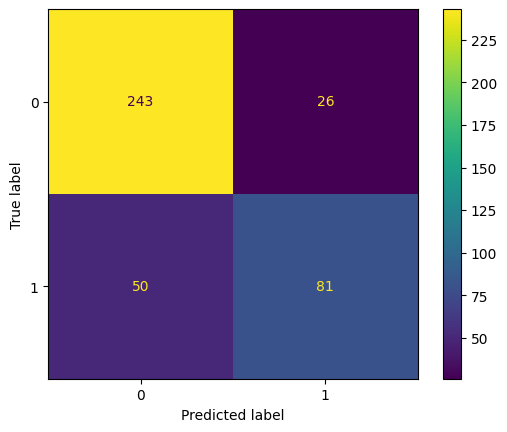

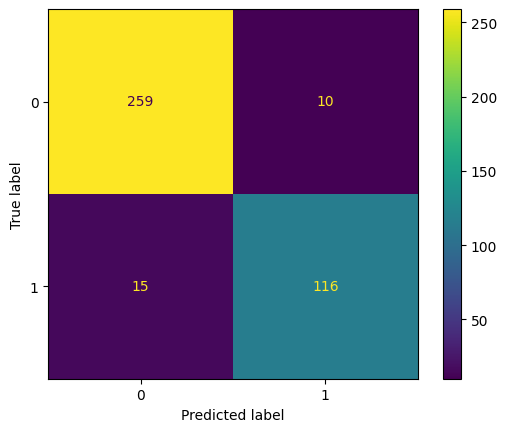

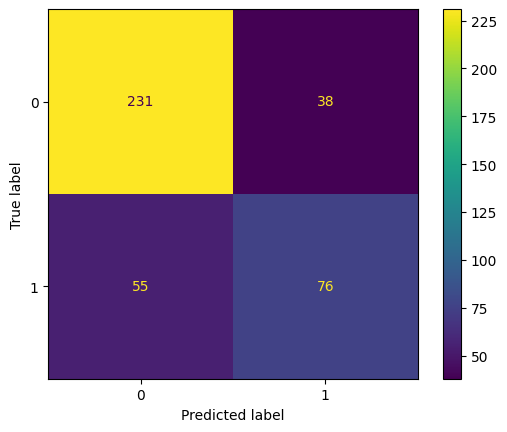

In [104]:
# 7. Extract Results:

# Linear model:
y_hat_lm = np.round(lm.predict(X_test)) # Predicted values
print('Linear Model rsq: ', accuracy_score(y_test, y_hat_lm) ) 
print('Linear Model MCC: ', matthews_corrcoef(y_test, y_hat_lm))

cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_hat_lm))
cm.plot()
##########################################################

# Tree:
y_hat_tree = tree.predict(X_test)
print('Tree accuracy: ', tree.score(X_test, y_test) ) 
print('Tree MCC: ', matthews_corrcoef(y_test, y_hat_tree))

cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_hat_tree))
cm.plot()
##########################################################

# k Nearest Neighbor:
y_hat_knn = knn.predict(X_test)
print('kNN accuracy: ', knn.score(X_test, y_test) ) 
print('kNN MCC: ', matthews_corrcoef(y_test, y_hat_knn))

cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_hat_knn))
cm.plot()

## Example: Credit Default
- `'./data/brazil_default.csv'`
- 50000 observations of 54 socio-economic/demographic variables on account holders in Brazil like income, age, residence type, marital status, etc.
- The target variable is whether they fail to pay their debt on the account, which is defaulting: We want to predict default status through regression or classification